<a href="https://colab.research.google.com/github/yblee110/jax-flax-book/blob/main/ch03_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax
import flax
import optax


print("JAX Version : {}".format(jax.__version__))
print("FLAX Version : {}".format(flax.__version__))
print("OPTAX Version : {}".format(optax.__version__))

JAX Version : 0.4.20
FLAX Version : 0.7.5
OPTAX Version : 0.1.7


In [5]:
!pip install datasets

import jax.numpy as jnp
from datasets import load_dataset


def get_datasets():
    datasets = load_dataset("mnist")
    datasets = datasets.with_format("jax")
    datasets = {
        "train": {
            "image": datasets["train"]["image"][..., None].astype(jnp.float32)/255,
            "label": datasets["train"]["label"],
        },
        "test": {
            "image": datasets["test"]["image"][..., None].astype(jnp.float32)/255,
            "label": datasets["test"]["label"],
        },
    }
    return datasets['train'], datasets['test']

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00


In [6]:
train_ds, test_ds = get_datasets()

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [8]:
from flax import linen as nn


class CNN(nn.Module):
    num_classes: int

    def setup(self):
        self.conv1 = nn.Conv(features=16, kernel_size=(5, 5), strides=(2, 2), padding='VALID')
        self.conv2 = nn.Conv(features=16, kernel_size=(5, 5), strides=(2, 2), padding='VALID')
        self.dense1 = nn.Dense(features=self.num_classes)

    def __call__(self, x,):
        x = self.conv1(x)
        x = nn.relu(x)
        x = self.conv2(x)
        x = nn.relu(x)
        x = jnp.mean(x, axis=(1, 2))
        x = self.dense1(x)
        return x

In [9]:
from flax import linen as nn


class CNN(nn.Module):
   num_classes: int


   @nn.compact
   def __call__(self, x,):
       x = nn.Conv(features=16, kernel_size=(5, 5), strides=(2, 2), padding='VALID')(x)
       x = nn.relu(x)
       x = nn.Conv(features=32, kernel_size=(5, 5), strides=(2, 2), padding='VALID')(x)
       x = nn.relu(x)
       x = jnp.mean(x, axis=(1, 2))
       x = nn.Dense(features=self.num_classes)(x)
       return x

In [10]:
rng = jax.random.PRNGKey(0)
model = CNN(num_classes=10)
rng, key = jax.random.split(rng)
variables = model.init(key, jnp.ones((1, 28, 28, 1)))
params = variables['params']

In [12]:
print(model.tabulate(key, jnp.ones((1, 28, 28, 1))))


                                         CNN Summary                                         
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs              ┃ outputs             ┃ params                     ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ CNN    │ float32[1,28,28,1]  │ float32[1,10]       │                            │
├─────────┼────────┼─────────────────────┼─────────────────────┼────────────────────────────┤
│ Conv_0  │ Conv   │ float32[1,28,28,1]  │ float32[1,12,12,16] │ bias: float32[16]          │
│         │        │                     │                     │ kernel: float32[5,5,1,16]  │
│         │        │                     │                     │                            │
│         │        │                     │                     │ 416 (1.7 KB)               │
├─────────┼────────┼─────────────────────┼─────────────────

In [13]:
def compute_metrics(logits, labels):
    loss = jnp.mean(optax.softmax_cross_entropy(logits,
                    jax.nn.one_hot(labels, num_classes=10)))
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
        'loss': loss,
        'accuracy': accuracy
    }
    return metrics

In [14]:
from flax.training.train_state import TrainState


learning_rate = 0.001
tx = optax.adam(learning_rate=learning_rate)


state = TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=tx,
)

In [15]:
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch['image'])
        loss = jnp.mean(optax.softmax_cross_entropy(
            logits=logits,
            labels=jax.nn.one_hot(batch['label'], num_classes=10))
        )
        return loss, logits
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)


    metrics = compute_metrics(logits, batch['label'])
    return state, metrics



In [16]:
@jax.jit
def eval_step(state, batch):
    logits = state.apply_fn({'params': state.params}, batch['image'])
    return compute_metrics(logits, batch['label'])

In [17]:
def train_loop(state, train_ds, batch_size, epoch, rng):
    train_ds_size = len(train_ds['image'])
    steps_per_epoch = train_ds_size // batch_size


    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[:steps_per_epoch * batch_size]  # Skip an incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))

    batch_metrics = []
    for perm in perms:
        batch = {k: v[perm, ...] for k, v in train_ds.items()}
        state, metrics = train_step(state, batch)
        batch_metrics.append(metrics)


    training_batch_metrics = jax.device_get(batch_metrics)
    training_epoch_metrics = {
        k: sum([metrics[k] for metrics in training_batch_metrics])/steps_per_epoch
        for k in training_batch_metrics[0]}


    print('EPOCH: %d\nTraining loss: %.4f, accuracy: %.2f' % (epoch, training_epoch_metrics['loss'], training_epoch_metrics['accuracy'] * 100))
    return state


In [18]:
def eval_loop(state, test_ds, batch_size):
    eval_ds_size = test_ds['image'].shape[0]
    steps_per_epoch = eval_ds_size // batch_size


    batch_metrics = []
    for i in range(steps_per_epoch):
        batch = {k: v[i*batch_size:(i+1)*batch_size, ...] for k, v in test_ds.items()}
        metrics = eval_step(state, batch)
        batch_metrics.append(metrics)


    eval_batch_metrics = jax.device_get(batch_metrics)
    eval_batch_metrics = {
        k: sum([metrics[k] for metrics in eval_batch_metrics])/steps_per_epoch
        for k in eval_batch_metrics[0]}
    print('    Eval loss: %.4f, accuracy: %.2f' % (eval_batch_metrics['loss'], eval_batch_metrics['accuracy'] * 100))


In [19]:
train_epoch = 10
batch_size = 64
eval_batch_size = 100

for epoch in range(train_epoch):
    rng, key = jax.random.split(rng)
    state = train_loop(state, train_ds, batch_size, epoch, rng)
    eval_loop(state, test_ds, eval_batch_size)

EPOCH: 0
Training loss: 0.8403, accuracy: 75.84
    Eval loss: 0.3673, accuracy: 89.74
EPOCH: 1
Training loss: 0.3265, accuracy: 90.72
    Eval loss: 0.2359, accuracy: 93.19
EPOCH: 2
Training loss: 0.2482, accuracy: 92.79
    Eval loss: 0.2033, accuracy: 93.96
EPOCH: 3
Training loss: 0.2067, accuracy: 94.00
    Eval loss: 0.1751, accuracy: 94.85
EPOCH: 4
Training loss: 0.1797, accuracy: 94.72
    Eval loss: 0.1452, accuracy: 95.86
EPOCH: 5
Training loss: 0.1631, accuracy: 95.22
    Eval loss: 0.1339, accuracy: 96.05
EPOCH: 6
Training loss: 0.1494, accuracy: 95.56
    Eval loss: 0.1383, accuracy: 95.82
EPOCH: 7
Training loss: 0.1367, accuracy: 95.99
    Eval loss: 0.1327, accuracy: 96.07
EPOCH: 8
Training loss: 0.1296, accuracy: 96.14
    Eval loss: 0.1017, accuracy: 97.00
EPOCH: 9
Training loss: 0.1190, accuracy: 96.49
    Eval loss: 0.1051, accuracy: 96.98


In [20]:
@jax.jit
def pred_step(state, batch):
    logits = state.apply_fn({'params': state.params}, batch)
    return logits.argmax(axis=1)

pred = pred_step(state, test_ds['image'][:25])

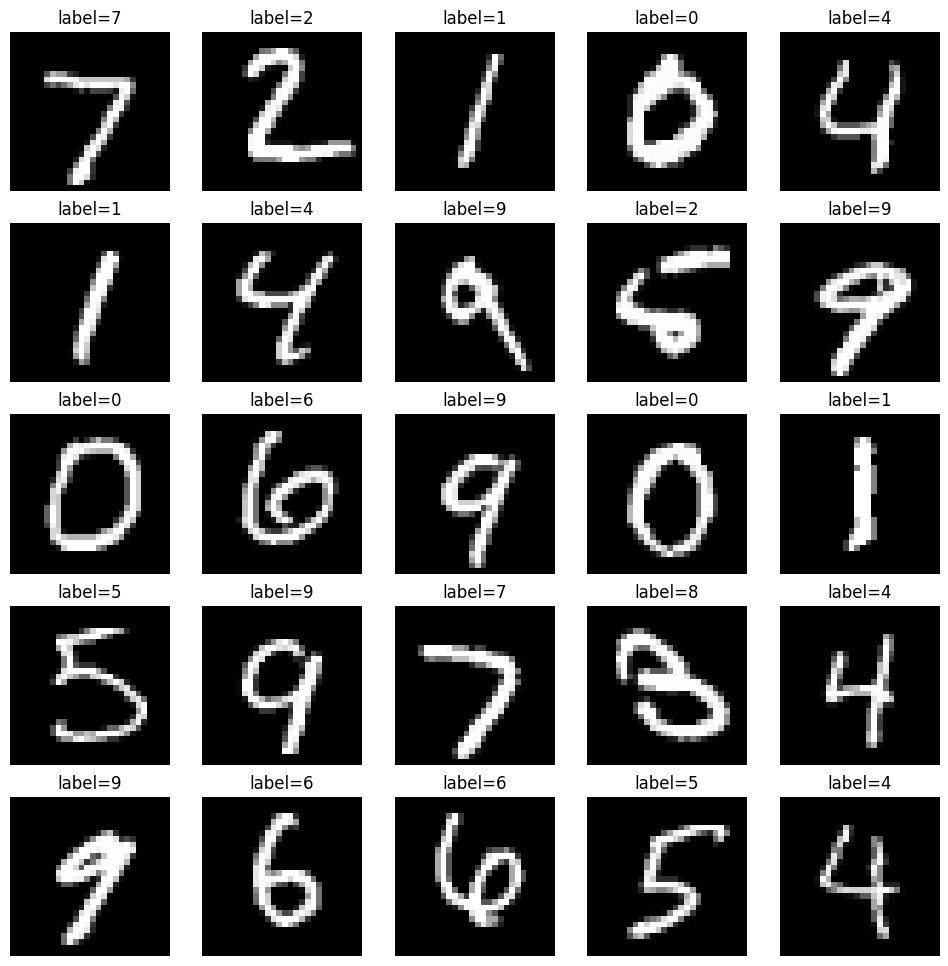

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
   ax.imshow(test_ds['image'][i], cmap='gray')
   ax.set_title(f"label={pred[i]}")
   ax.axis('off')